# Algo Backtests Are Lying to You (Companion Notebook)

Use this notebook alongside the post to recreate the charts, run stress-tests, and experiment with different assumptions. Each section mirrors the narrative from Gaussian comfort to quantile reality.


> **How to run**
> - Dependencies: `numpy`, `polars`, `matplotlib`, `seaborn`, `scipy`. Optional: `plotly` for your own experiments.
> - With uv: `uv run --frozen jupyter lab` (or `uv run --frozen jupyter notebook`).
> - Change the global `rng` seed in the next cell to explore different worlds.


In [1]:
import math
from dataclasses import dataclass
from typing import Iterable

import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
from backtesting import Backtest, Strategy, set_bokeh_output
from scipy import stats

pl.Config.set_tbl_formatting("UTF8_FULL")
pl.Config.set_tbl_rows(200)
pl.Config.set_tbl_cols(12)
plt.rcParams.update({"figure.figsize": (12, 6), "figure.dpi": 120})
sns.set_theme(style="whitegrid", context="talk")

rng = np.random.default_rng(3)
DAYS_PER_YEAR = 252

/Users/johannes/Repos/convex/.venv/lib/python3.14/site-packages/backtesting/_plotting.py:55: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support, such as old IDEs. Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [2]:
def returns_to_prices(returns: np.ndarray, start_price: float = 100.0) -> np.ndarray:
    levels = np.cumprod(1 + returns)
    return np.insert(start_price * levels, 0, start_price)


def gaussian_returns(n_days: int, mu: float = 0.0004, sigma: float = 0.015) -> np.ndarray:
    return rng.normal(mu, sigma, size=n_days)


def student_t_returns(n_days: int, mu: float = 0.0002, sigma: float = 0.02, df: int = 3) -> np.ndarray:
    # Student-t with fat tails; scaled to match daily vol roughly equal to sigma
    return mu + sigma * rng.standard_t(df, size=n_days)


def inject_shocks(returns: np.ndarray, shock_probability: float = 0.01, tail_scale: float = 0.25) -> np.ndarray:
    shocked = returns.copy()
    mask = rng.random(len(returns)) < shock_probability
    if mask.any():
        shocks = rng.pareto(3.0, mask.sum()) * tail_scale
        shocked[mask] -= shocks
    return shocked


def equity_curve(simple_returns: pl.Series, start: float = 1.0) -> pl.Series:
    arr = np.cumprod(1 + simple_returns.to_numpy())
    return pl.Series("equity", start * arr)


def strategy_metrics(simple_returns: pl.Series, label: str) -> pl.DataFrame:
    arr = simple_returns.to_numpy()
    if arr.size == 0:
        return pl.DataFrame({"metric": [], "value": [], "label": []})

    total_equity = float(np.prod(1 + arr))
    total_return = total_equity - 1.0
    if total_equity > 0:
        ann_return = float(total_equity ** (DAYS_PER_YEAR / arr.size) - 1)
    else:
        ann_return = float('nan')

    ann_vol = float(np.sqrt(DAYS_PER_YEAR) * arr.std(ddof=1)) if arr.size > 1 else float('nan')
    sharpe = float(ann_return / ann_vol) if ann_vol > 0 and np.isfinite(ann_return) else float('nan')

    equity = np.cumprod(1 + arr)
    rolling_max = np.maximum.accumulate(equity)
    drawdowns = equity / rolling_max - 1
    max_dd = float(drawdowns.min())

    hit_rate = float(np.mean(arr > 0))

    return pl.DataFrame({
        "metric": [
            "Total return",
            "Annualized return",
            "Annualized vol",
            "Sharpe",
            "Max drawdown",
            "Hit rate",
        ],
        "value": [
            total_return,
            ann_return,
            ann_vol,
            sharpe,
            max_dd,
            hit_rate,
        ],
        "label": [label] * 6,
    })

def run_sma_crossover(prices: np.ndarray, short_window: int = 20, long_window: int = 100, slippage_bps: float = 5.0) -> pl.DataFrame:
    fee = slippage_bps / 10_000
    df = pl.DataFrame({"price": prices})
    df = df.with_columns([
        (pl.col("price") / pl.col("price").shift(1) - 1).alias("return"),
        pl.col("price").rolling_mean(short_window).alias("sma_short"),
        pl.col("price").rolling_mean(long_window).alias("sma_long"),
    ])

    df = df.with_columns(
        (pl.col("sma_short") > pl.col("sma_long")).cast(pl.Int8).alias("signal")
    )

    df = df.with_columns([
        pl.col("signal").shift(1).fill_null(0).alias("position"),
        pl.col("signal").diff().abs().fill_null(0).alias("turnover"),
    ])

    df = df.with_columns(
        (pl.col("position") * pl.col("return") - pl.col("turnover") * fee).alias("strategy_return")
    )

    df = df.drop_nulls(subset=["return", "sma_short", "sma_long"])
    return df


def plot_price_and_equity(df: pl.DataFrame, title: str):
    fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    axes[0].plot(df["price"].to_numpy(), color="black", label="Price")
    axes[0].plot(df["sma_short"].to_numpy(), label="SMA (short)")
    axes[0].plot(df["sma_long"].to_numpy(), label="SMA (long)")
    axes[0].set_ylabel("Price")
    axes[0].legend()

    equity = equity_curve(df["strategy_return"])
    axes[1].plot(equity.to_numpy(), color="tab:blue", label="Strategy equity")
    axes[1].set_ylabel("Equity")
    axes[1].set_xlabel("Observation")
    axes[1].legend()

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()


def convex_payoff(x: np.ndarray) -> np.ndarray:
    return np.exp(4 * x) - 1


def concave_payoff(x: np.ndarray) -> np.ndarray:
    return 1 - np.exp(-4 * x)


## 1. Gaussian Comfort Zone

A spotless backtest often lives in a world where returns are close to Gaussian, volatility is well-behaved, and the future politely resembles the past. Let’s recreate that illusion.


metric,value,label
str,f64,str
"""Total return""",1.465895,"""Gaussian regime"""
"""Annualized return""",0.176128,"""Gaussian regime"""
"""Annualized vol""",0.193347,"""Gaussian regime"""
"""Sharpe""",0.910943,"""Gaussian regime"""
"""Max drawdown""",-0.211505,"""Gaussian regime"""
"""Hit rate""",0.370185,"""Gaussian regime"""


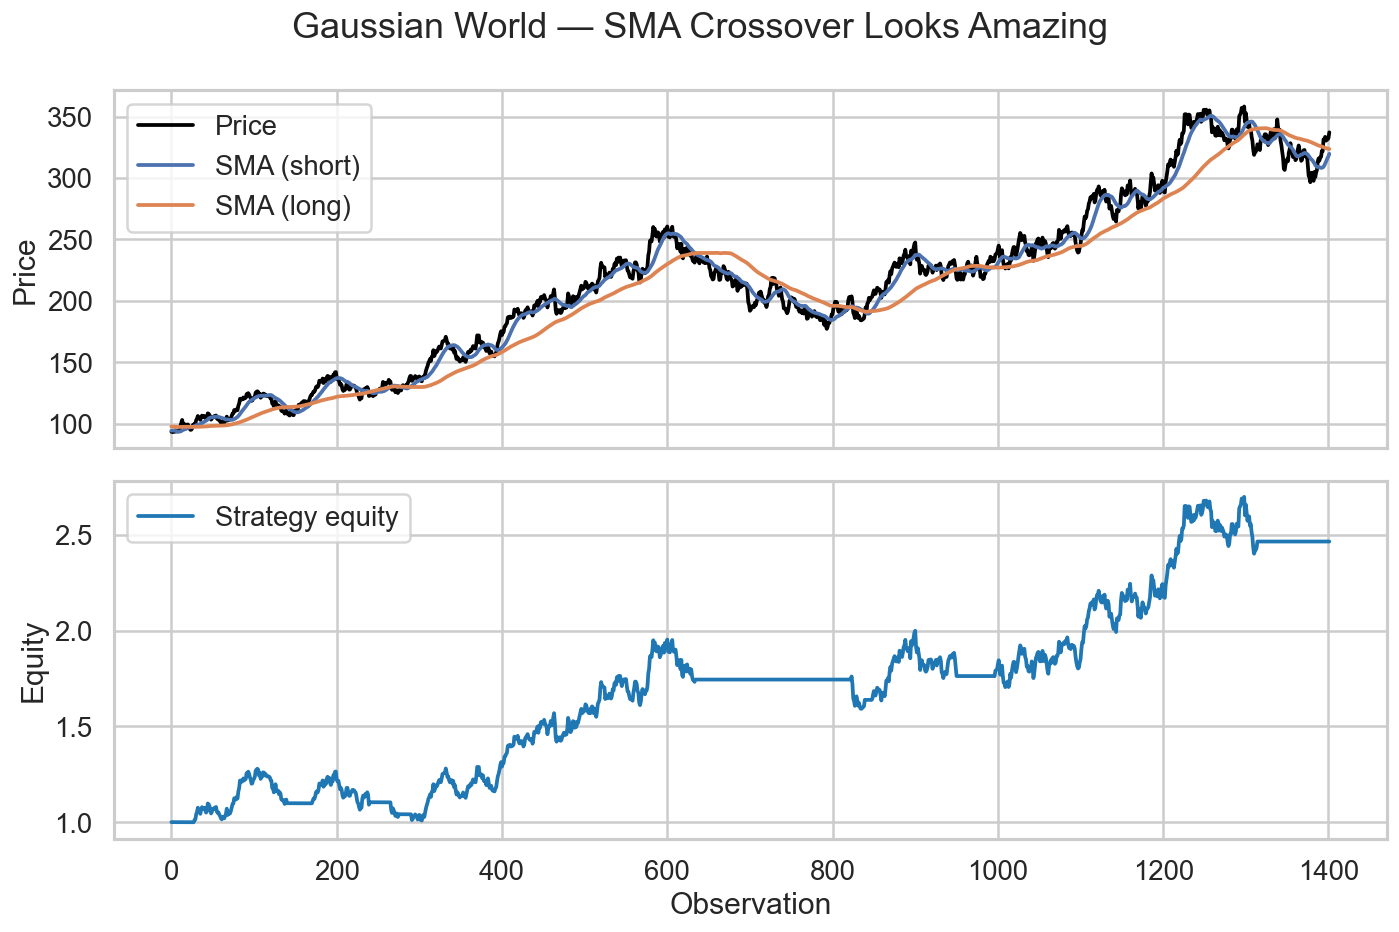

In [3]:
n_days = 1500
base_returns = gaussian_returns(n_days)
prices_gaussian = returns_to_prices(base_returns)

sma_gaussian = run_sma_crossover(prices_gaussian)
metrics_gaussian = strategy_metrics(sma_gaussian["strategy_return"], label="Gaussian regime")

display(metrics_gaussian)
plot_price_and_equity(sma_gaussian, title="Gaussian World — SMA Crossover Looks Amazing")


Everything looks measured: smooth equity, tolerable drawdowns, and a tidy Sharpe. This is the comfort zone most decks rely on before pitching capital.


## 2. Fat Tails Ruin the Script

Real markets feature clustered volatility and Pareto tails. We start by contrasting distributions, then drop the same strategy into a heavy-tailed world with random shocks.


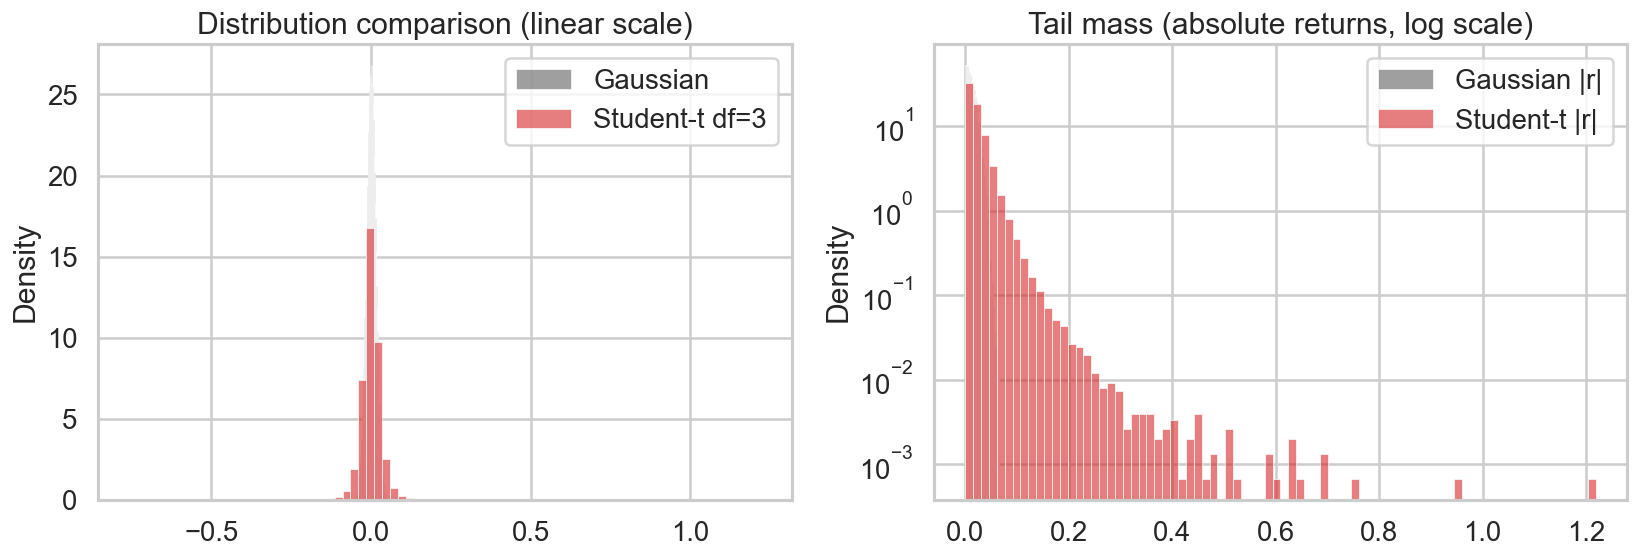

P(|r| > 5%) Gaussian: 0.0008
P(|r| > 5%) Student-t: 0.0878


In [4]:
sample_size = 100_000
norm_sample = gaussian_returns(sample_size)
t_sample = student_t_returns(sample_size, df=3)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(norm_sample, bins=80, stat="density", color="tab:gray", label="Gaussian", ax=axes[0])
sns.histplot(t_sample, bins=80, stat="density", color="tab:red", label="Student-t df=3", ax=axes[0], alpha=0.6)
axes[0].set_title("Distribution comparison (linear scale)")
axes[0].legend()

sns.histplot(np.abs(norm_sample), bins=80, stat="density", color="tab:gray", ax=axes[1], label="Gaussian |r|")
sns.histplot(np.abs(t_sample), bins=80, stat="density", color="tab:red", ax=axes[1], label="Student-t |r|", alpha=0.6)
axes[1].set_title("Tail mass (absolute returns, log scale)")
axes[1].set_yscale("log")
axes[1].legend()

plt.tight_layout()
plt.show()

p_gauss_tail = np.mean(np.abs(norm_sample) > 0.05)
p_t_tail = np.mean(np.abs(t_sample) > 0.05)
print(f"P(|r| > 5%) Gaussian: {p_gauss_tail:.4f}")
print(f"P(|r| > 5%) Student-t: {p_t_tail:.4f}")


metric,value,label
str,f64,str
"""Total return""",-0.609389,"""Fat-tailed regime"""
"""Annualized return""",-0.155463,"""Fat-tailed regime"""
"""Annualized vol""",0.34599,"""Fat-tailed regime"""
"""Sharpe""",-0.449327,"""Fat-tailed regime"""
"""Max drawdown""",-0.800496,"""Fat-tailed regime"""
"""Hit rate""",0.121969,"""Fat-tailed regime"""


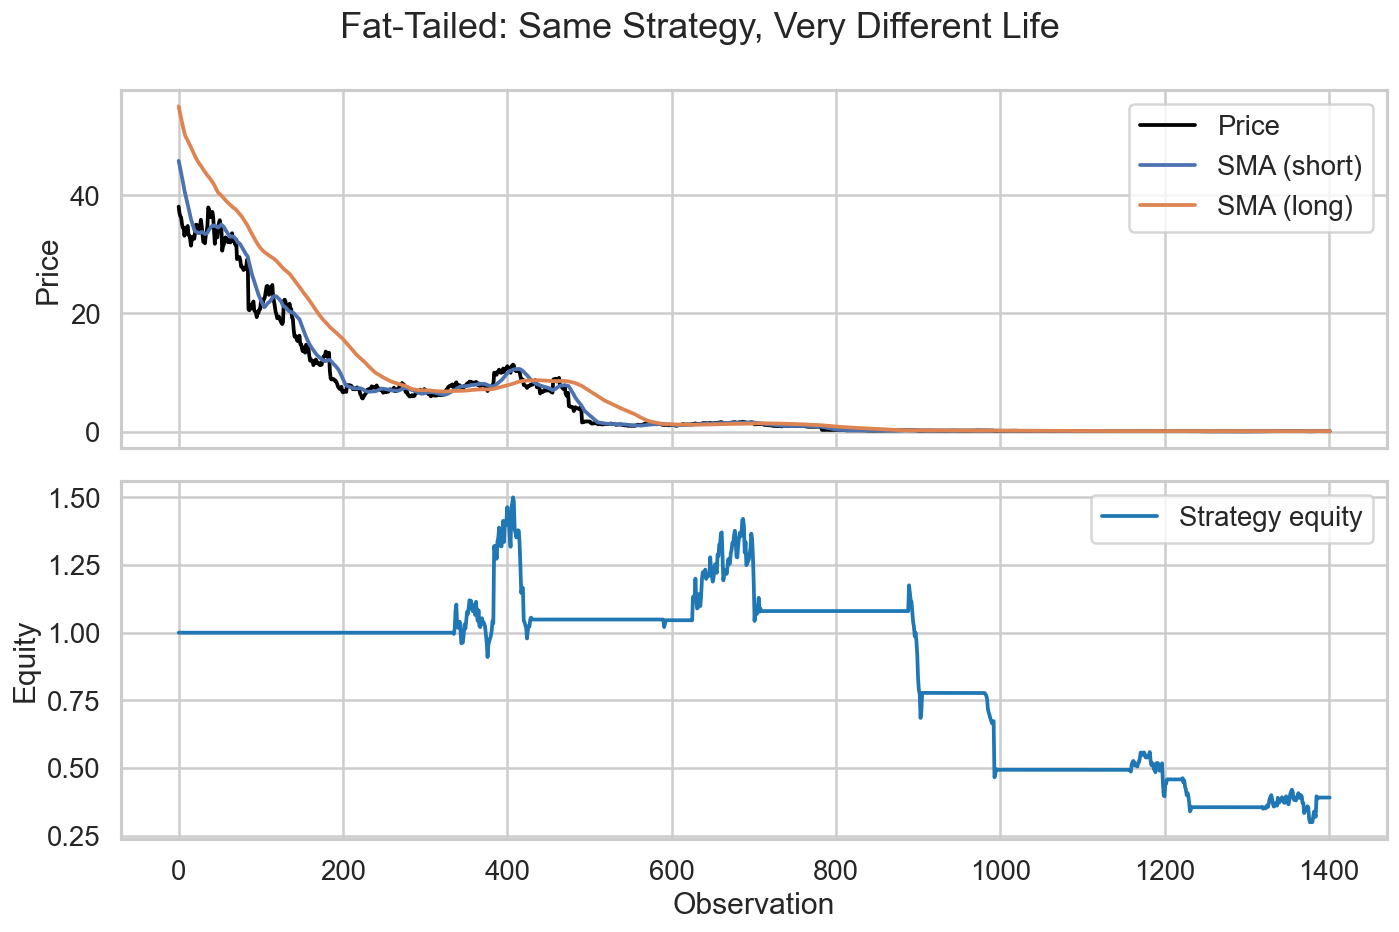

In [5]:
fat_tail_returns = inject_shocks(student_t_returns(n_days, sigma=0.025, df=3), shock_probability=0.008, tail_scale=0.35)
prices_fat_tail = returns_to_prices(fat_tail_returns)

sma_fat_tail = run_sma_crossover(prices_fat_tail)
metrics_fat_tail = strategy_metrics(sma_fat_tail["strategy_return"], label="Fat-tailed regime")

display(metrics_fat_tail)
plot_price_and_equity(sma_fat_tail, title="Fat-Tailed: Same Strategy, Very Different Life")


A handful of adverse days obliterate the glossy Sharpe. The slippage penalty barely matters and the regime shift dominates. The chart dramatizes why a single out-of-sample event can erase years of paper profits.


## 3. Quantile Check

Means smooth out the very risk we worry about. Quantiles expose which parts of the payoff surface never appear in historical samples.


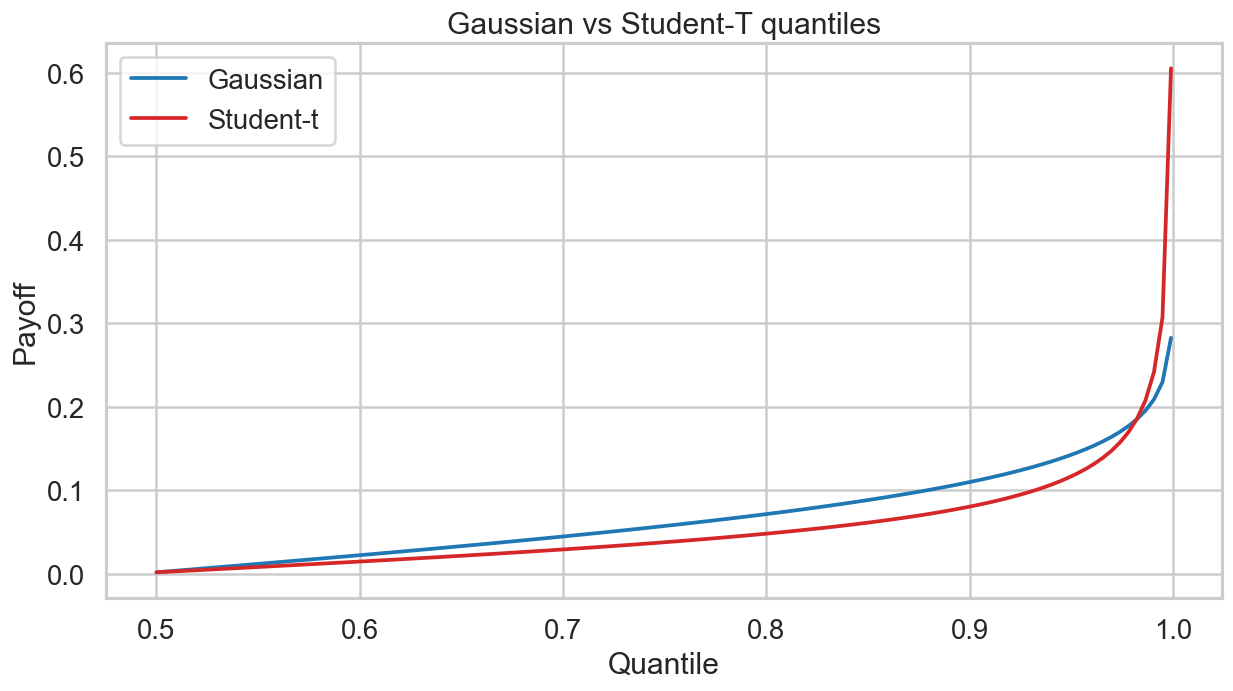

Convex payoff at 99.9% quantile (Gaussian): 0.28
Convex payoff at 99.9% quantile (Student-t): 0.61


In [6]:
quantiles = np.linspace(0.50, 0.999, 120)
mu, sigma = 0.0004, 0.02

norm = stats.norm(loc=mu, scale=sigma)
t_dist = stats.t(df=3, loc=mu, scale=sigma * math.sqrt((3 - 2) / 3))  # scale so variance roughly matches

gauss_tail = norm.ppf(quantiles)
student_tail = t_dist.ppf(quantiles)

convex_gauss = convex_payoff(gauss_tail)
convex_student = convex_payoff(student_tail)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(quantiles, convex_gauss, label="Gaussian", color="tab:blue")
ax.plot(quantiles, convex_student, label="Student-t", color="tab:red")
# ax.axvspan(0.99, quantiles[-1], color="tab:red", alpha=0.1, label="Missing 1% in backtest")
ax.set_xlabel("Quantile")
ax.set_ylabel("Payoff")
ax.set_title("Gaussian vs Student-T quantiles")
ax.legend()
plt.show()

print(f"Convex payoff at 99.9% quantile (Gaussian): {convex_gauss[-1]:.2f}")
print(f"Convex payoff at 99.9% quantile (Student-t): {convex_student[-1]:.2f}")


The convex strategy feasts in the tail region the Gaussian world barely touches. If your data never visits that zone, your estimate of risk is fantasy.


## 4. Convex vs Concave Monte Carlo

Jensen’s inequality says convex strategies benefit from volatility while concave ones die from it. We run parallel Monte Carlo experiments under both regimes.


regime,payoff,mean,std,p05,p95
str,str,f64,f64,f64,f64
"""Gaussian""","""Convex""",0.833187,0.970042,-0.709841,2.355589
"""Student-t""","""Concave""",-6.531372,70.82744,-7.258983,1.326369
"""Gaussian""","""Concave""",-0.071525,0.964297,-1.637306,1.447169
"""Student-t""","""Convex""",2.780661,2.571356,-1.020529,7.202836


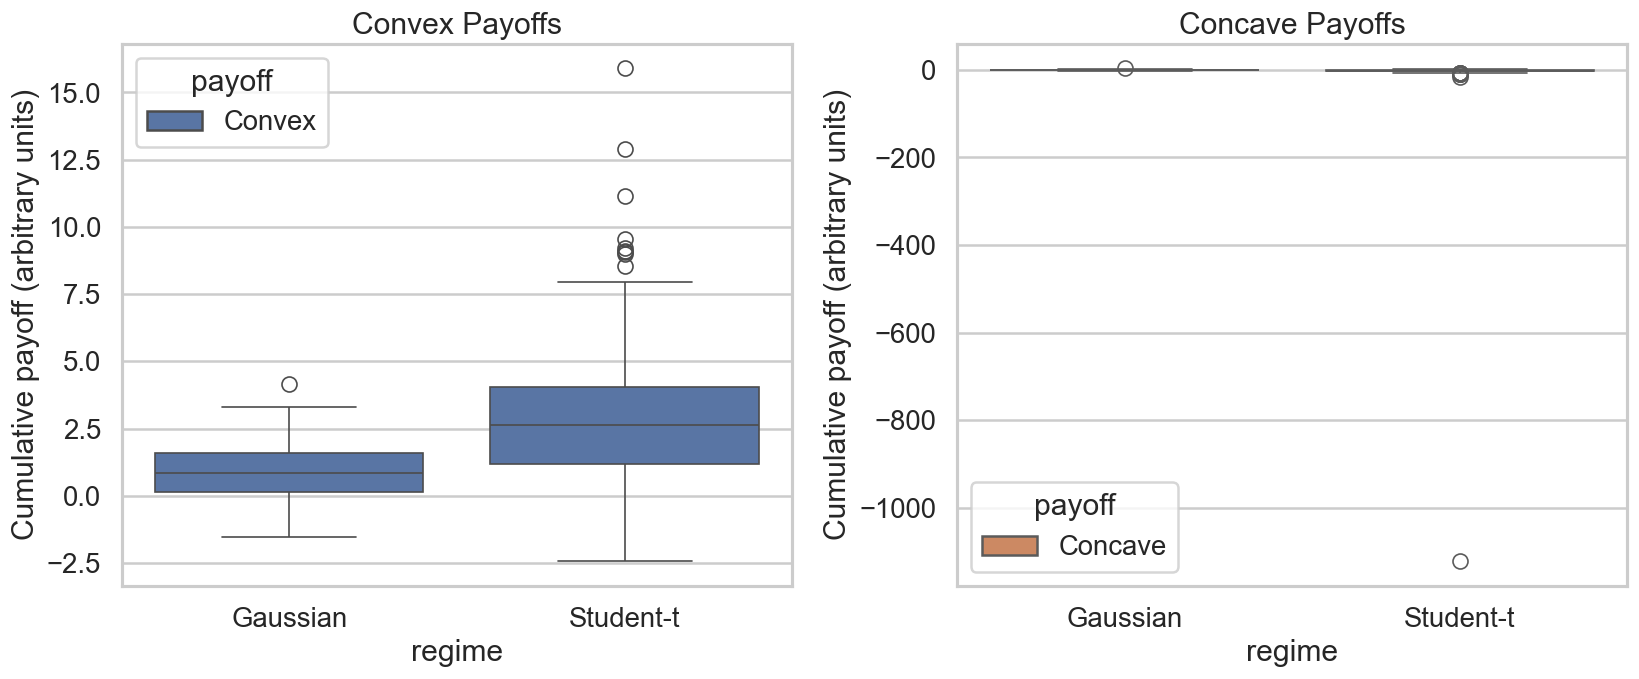

E[f(X)] = 0.0121 vs f(E[X]) = 0.0026 (Jensen gap 0.0095)


In [7]:
paths, path_length = 250, 252
records = []

for regime, sampler in [
    ("Gaussian", lambda: gaussian_returns(path_length, sigma=0.015)),
    ("Student-t", lambda: student_t_returns(path_length, sigma=0.02, df=3)),
]:
    for run in range(paths):
        r = sampler()
        convex_total = convex_payoff(r).sum()
        concave_total = concave_payoff(r).sum()
        records.extend([
            {"regime": regime, "payoff": "Convex", "total": convex_total},
            {"regime": regime, "payoff": "Concave", "total": concave_total},
        ])

mc_df = pl.DataFrame(records)
mc_summary = mc_df.group_by(["regime", "payoff"]).agg([
    pl.col("total").mean().alias("mean"),
    pl.col("total").std().alias("std"),
    pl.col("total").quantile(0.05).alias("p05"),
    pl.col("total").quantile(0.95).alias("p95"),
])

display(mc_summary)

# plt.figure(figsize=(12, 6))
# sns.boxplot(data=mc_df.to_pandas(), x="regime", y="total", hue="payoff")
# plt.title("Convex strategies benefit from volatility; concave ones lose")
# plt.ylabel("Cumulative payoff (arbitrary units)")
# ax.set_yscale('symlog') 
# plt.show()

df = mc_df.to_pandas()
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

sns.boxplot(
    data=df.query("payoff == 'Convex'"),
    x="regime", y="total", hue="payoff", ax=axes[0], palette=["#4C72B0"]
)
axes[0].set_title("Convex Payoffs")

sns.boxplot(
    data=df.query("payoff == 'Concave'"),
    x="regime", y="total", hue="payoff", ax=axes[1], palette=["#DD8452"]
)
axes[1].set_title("Concave Payoffs")

for ax in axes:
    ax.set_ylabel("Cumulative payoff (arbitrary units)")

plt.tight_layout()
plt.show()


# Jensen gap illustration
sample_returns = student_t_returns(10_000, sigma=0.02, df=3)
left = convex_payoff(sample_returns).mean()
right = convex_payoff(sample_returns.mean())
print(f"E[f(X)] = {left:.4f} vs f(E[X]) = {right:.4f} (Jensen gap {left - right:.4f})")


Convex exposures (long gamma, long options) have lumpy upside but survive. Concave payoffs (short gamma, carry trades) hug the mean until a tail clamps down. The Jensen gap highlights why averages lie.


## 5. Regime Shifts & Stress-Testing Checklist

Finally, we stitch together a quick regime-shift simulator that introduces policy shocks, volatility clustering, and trend breaks. Use it as a template for falsification.


metric,value,label
str,f64,str
"""Total return""",-0.904882,"""Regime stress test"""
"""Annualized return""",-0.470658,"""Regime stress test"""
"""Annualized vol""",0.458266,"""Regime stress test"""
"""Sharpe""",-1.027042,"""Regime stress test"""
"""Max drawdown""",-0.923123,"""Regime stress test"""
"""Hit rate""",0.139485,"""Regime stress test"""


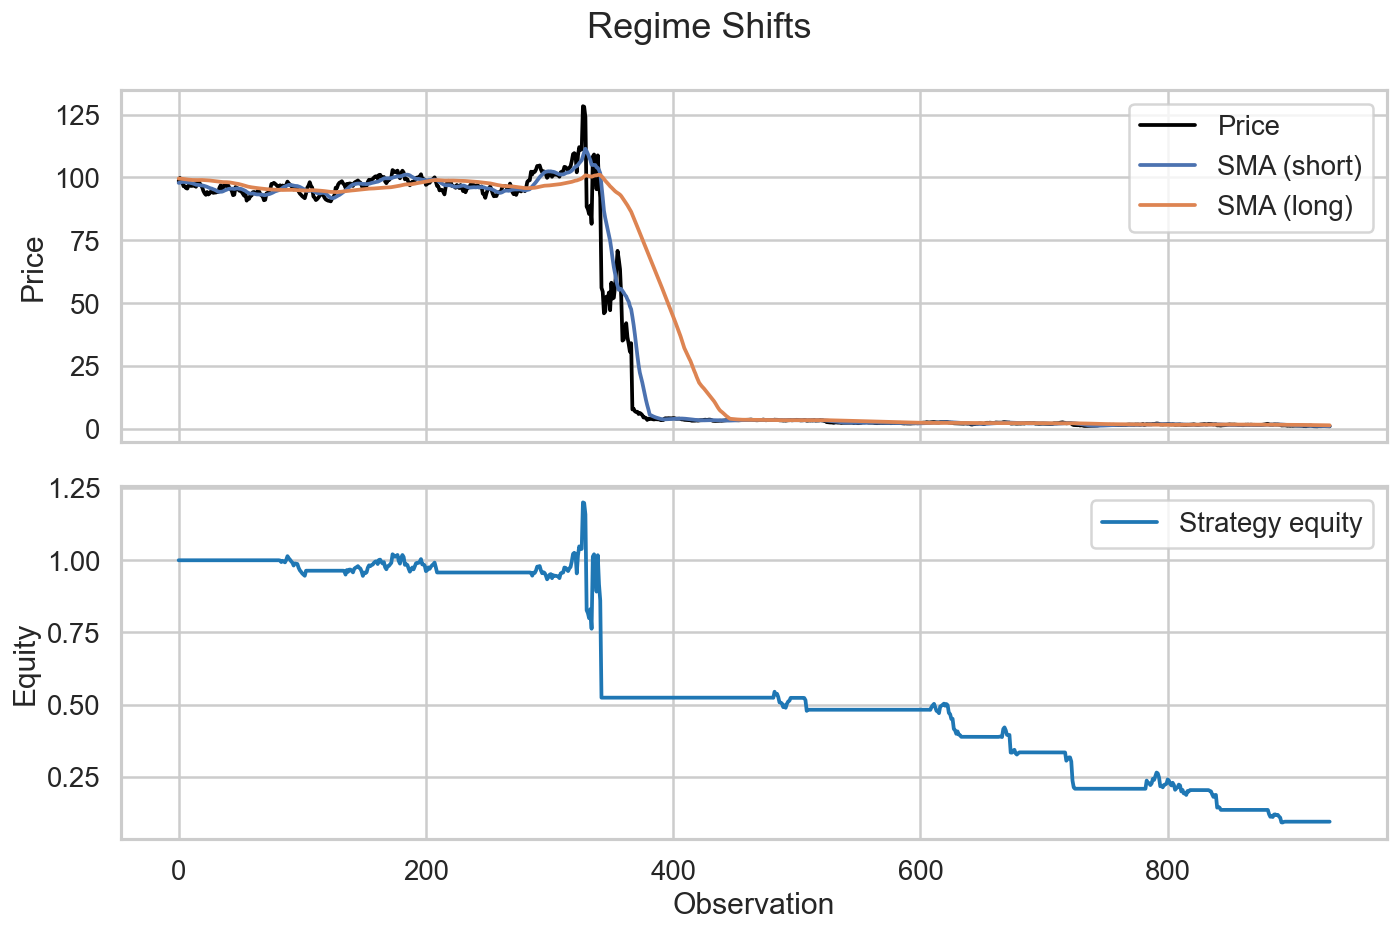

In [8]:
@dataclass
class Regime:
    length: int
    mu: float
    sigma: float
    df: int = 5
    shock_probability: float = 0.0
    shock_scale: float = 0.0


def regime_returns(regimes: Iterable[Regime]) -> np.ndarray:
    chunks = []
    for regime in regimes:
        base = regime.mu + regime.sigma * rng.standard_t(regime.df, size=regime.length)
        if regime.shock_probability > 0:
            base = inject_shocks(base, shock_probability=regime.shock_probability, tail_scale=regime.shock_scale)
        chunks.append(base)
    return np.concatenate(chunks)


stress_regimes = [
    Regime(length=400, mu=0.0005, sigma=0.01, df=8),     # calm bull market
    Regime(length=60, mu=-0.03, sigma=0.09, df=3, shock_probability=0.1, shock_scale=0.4),  # policy shock
    Regime(length=250, mu=0.0002, sigma=0.02, df=5),     # choppy recovery
    Regime(length=300, mu=0.0000, sigma=0.035, df=4, shock_probability=0.02, shock_scale=0.25),  # volatility cluster
]

stress_returns = regime_returns(stress_regimes)
prices_stress = returns_to_prices(stress_returns)

sma_stress = run_sma_crossover(prices_stress, short_window=15, long_window=80, slippage_bps=8)
metrics_stress = strategy_metrics(sma_stress["strategy_return"], label="Regime stress test")

display(metrics_stress)
plot_price_and_equity(sma_stress, title="Regime Shifts")


This synthetic path combines the checklist items from the post: regime shifts, slippage, fat tails. Adjust the `Regime` list to mimic your own assumptions and use the failures to falsify strategies quickly.


## 6. Real-Data Sanity Check with `backtesting.py`

We rerun the SMA crossover on actual SPY and BTC-USD daily candles via `backtesting.py`. A calm decade looks brilliant, but stress windows expose the same fragility we saw in simulation.


In [9]:
def rolling_sma(values, window):
    series = pd.Series(values)
    return series.rolling(window).mean().to_numpy()


def crossed_above(fast, slow):
    if len(fast) < 2 or len(slow) < 2:
        return False
    a_prev, a_curr = fast[-2], fast[-1]
    b_prev, b_curr = slow[-2], slow[-1]
    if any(np.isnan(v) for v in (a_prev, a_curr, b_prev, b_curr)):
        return False
    return a_prev <= b_prev and a_curr > b_curr


def crossed_below(fast, slow):
    if len(fast) < 2 or len(slow) < 2:
        return False
    a_prev, a_curr = fast[-2], fast[-1]
    b_prev, b_curr = slow[-2], slow[-1]
    if any(np.isnan(v) for v in (a_prev, a_curr, b_prev, b_curr)):
        return False
    return a_prev >= b_prev and a_curr < b_curr


class SMACrossover(Strategy):
    short_window = 20
    long_window = 100
    slippage_bps = 5

    def init(self):
        self.sma_short = self.I(rolling_sma, self.data.Close, self.short_window)
        self.sma_long = self.I(rolling_sma, self.data.Close, self.long_window)

    def next(self):
        if np.isnan(self.sma_short[-1]) or np.isnan(self.sma_long[-1]):
            return
        if crossed_above(self.sma_short, self.sma_long):
            if not self.position.is_long:
                self.position.close()
                self.buy()
        elif crossed_below(self.sma_short, self.sma_long):
            if self.position.is_long:
                self.position.close()


def fetch_history(symbol: str, start: str) -> pd.DataFrame:
    history = yf.download(symbol, start=start, auto_adjust=True, progress=False, actions=False, group_by="column")
    if isinstance(history.columns, pd.MultiIndex):
        history.columns = history.columns.droplevel(-1)
    required = ["Open", "High", "Low", "Close", "Volume"]
    history = history.loc[:, required].dropna()
    history.index = history.index.tz_localize(None)
    return history


def _pct(value: float | None) -> float:
    return float(value) / 100 if value is not None else float('nan')


def backtest_metrics(data: pd.DataFrame, label: str) -> tuple[pl.DataFrame, dict]:
    if len(data) < SMACrossover.long_window:
        raise ValueError(f"Need at least {SMACrossover.long_window} observations, got {len(data)}")

    commission = SMACrossover.slippage_bps / 10_000
    bt = Backtest(
        data,
        SMACrossover,
        cash=100_000,
        commission=commission,
        trade_on_close=True,
    )
    stats = bt.run()
    stats_dict = stats.to_dict()

    metrics = pl.DataFrame({
        "metric": [
            "Total return",
            "Annualized return",
            "Annualized vol",
            "Sharpe",
            "Max drawdown",
            "Hit rate",
        ],
        "value": [
            _pct(stats_dict.get("Return [%]")),
            _pct(stats_dict.get("CAGR [%]")),
            _pct(stats_dict.get("Volatility (ann.) [%]")),
            float(stats_dict.get("Sharpe Ratio", float('nan'))),
            _pct(stats_dict.get("Max. Drawdown [%]")),
            _pct(stats_dict.get("Win Rate [%]")),
        ],
        "label": [label] * 6,
    })

    return metrics, stats_dict





In [10]:
real_segments = {
    "SPY": [
        ("Calm 2010-2019", "2010-01-01", "2019-12-31"),
        ("GFC 2007-2009", "2007-01-01", "2009-12-31"),
        ("Pandemic 2020", "2020-01-01", "2020-12-31"),
    ],
    "BTC-USD": [
        ("Rally 2020-2021", "2020-01-01", "2021-11-01"),
        ("Crypto Winter 2021-2023", "2021-11-02", "2023-12-31"),
    ],
}

history_start = {
    "SPY": "2006-01-01",
    "BTC-USD": "2018-01-01",
}

metrics_tables: list[pl.DataFrame] = []
headline_rows: list[dict] = []

for symbol, segments in real_segments.items():
    history = fetch_history(symbol, start=history_start[symbol])

    for segment_label, start_date, end_date in segments:
        window = history.loc[start_date:end_date]
        if window.shape[0] < SMACrossover.long_window:
            print(f"Skipping {symbol} {segment_label}: {window.shape[0]} observations (< {SMACrossover.long_window})")
            continue

        label = f"{symbol} • {segment_label}"
        metrics, stats_dict = backtest_metrics(window, label)
        metrics_tables.append(metrics)

        headline_rows.append({
            "label": label,
            "total_return": _pct(stats_dict.get("Return [%]")),
            "cagr": _pct(stats_dict.get("CAGR [%]")),
            "sharpe": float(stats_dict.get("Sharpe Ratio", float('nan'))),
            "max_drawdown": _pct(stats_dict.get("Max. Drawdown [%]")),
        })

        ret = stats_dict.get("Return [%]")
        sharpe = stats_dict.get("Sharpe Ratio")
        mdd = stats_dict.get("Max. Drawdown [%]")
        if all(v is not None for v in (ret, sharpe, mdd)):
            print(f"{label}: Return {ret:.1f}% | Sharpe {sharpe:.2f} | Max DD {mdd:.1f}%")
        else:
            print(f"{label}: backtest complete (some summary metrics missing)")

if metrics_tables:
    display(pl.concat(metrics_tables))
else:
    print("No real-data metrics computed.")

if headline_rows:
    headline_df = pl.DataFrame(headline_rows)
    display(headline_df)



/var/folders/cm/0n7qvc_959b45wnwndf40yvw0000gn/T/ipykernel_44093/2187957758.py:73: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  stats = bt.run()
/var/folders/cm/0n7qvc_959b45wnwndf40yvw0000gn/T/ipykernel_44093/2187957758.py:73: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  stats = bt.run()
/var/folders/cm/0n7qvc_959b45wnwndf40yvw0000gn/T/ipykernel_44093/2187957758.py:73: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  stats = bt.run()


SPY • Calm 2010-2019: Return 105.0% | Sharpe 0.65 | Max DD -22.0%
SPY • GFC 2007-2009: Return 11.6% | Sharpe 0.33 | Max DD -19.8%
SPY • Pandemic 2020: Return 21.2% | Sharpe 1.22 | Max DD -9.4%
BTC-USD • Rally 2020-2021: Return 467.1% | Sharpe 1.00 | Max DD -39.5%
BTC-USD • Crypto Winter 2021-2023: Return 35.6% | Sharpe 0.49 | Max DD -21.2%


/var/folders/cm/0n7qvc_959b45wnwndf40yvw0000gn/T/ipykernel_44093/2187957758.py:73: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  stats = bt.run()
/var/folders/cm/0n7qvc_959b45wnwndf40yvw0000gn/T/ipykernel_44093/2187957758.py:73: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  stats = bt.run()


metric,value,label
str,f64,str
"""Total return""",1.049689,"""SPY • Calm 2010-2019"""
"""Annualized return""",0.050827,"""SPY • Calm 2010-2019"""
"""Annualized vol""",NaN,"""SPY • Calm 2010-2019"""
"""Sharpe""",0.649113,"""SPY • Calm 2010-2019"""
"""Max drawdown""",-0.219952,"""SPY • Calm 2010-2019"""
"""Hit rate""",0.666667,"""SPY • Calm 2010-2019"""
"""Total return""",0.11581,"""SPY • GFC 2007-2009"""
"""Annualized return""",0.025586,"""SPY • GFC 2007-2009"""
"""Annualized vol""",NaN,"""SPY • GFC 2007-2009"""


label,total_return,cagr,sharpe,max_drawdown
str,f64,f64,f64,f64
"""SPY • Calm 2010-2019""",1.049689,0.050827,0.649113,-0.219952
"""SPY • GFC 2007-2009""",0.11581,0.025586,0.326719,-0.197643
"""SPY • Pandemic 2020""",0.212071,0.142424,1.216621,-0.094328
"""BTC-USD • Rally 2020-2021""",4.671349,1.573892,1.004069,-0.39519
"""BTC-USD • Crypto Winter 2021-2…",0.355697,0.151171,0.48579,-0.211968


## Where to Tinker Next

- Swap in your own signals or payoff curves—use the helper functions to keep metrics consistent.
- Try adversarial shocks: draw shock size from a distribution conditioned on your leverage.
- Extend the `backtesting.py` section with your own instruments or intraday datasets to see where assumptions fail fastest.
